In [10]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [45]:
data = pd.read_stata("../CCES16_Common_OUTPUT_Feb2018_VV.dta")
xls_data = pd.read_excel('../federalelections2016.xlsx', sheet_name="2016 Pres General Results")
df = pd.DataFrame(data)


In [46]:
features = [
    "CC16_301a",
    "CC16_301b",
    "CC16_301c",
    "CC16_301d",
    "CC16_301e",
    "CC16_301f",
    "CC16_301g",
    "CC16_301h",
    "CC16_301i",
    "CC16_301j"
]
print(data["CC16_301a"].isna().sum())
data = data.dropna(subset=features)
print(data["CC16_301a"].isna().sum())
print(data["CC16_301a"])

51356
0
7            Very High Importance
20       Somewhat High Importance
22       Somewhat High Importance
26       Somewhat High Importance
30           Very High Importance
                   ...           
22597    Somewhat High Importance
22599    Somewhat High Importance
22678     Somewhat Low Importance
22685        Very High Importance
22862        No Importance at All
Name: CC16_301a, Length: 13171, dtype: category
Categories (5, object): ['Very High Importance' < 'Somewhat High Importance' < 'Somewhat Low Importance' < 'Very Low Importance' < 'No Importance at All']


In [49]:
# Filter CCES data for Trump/Clinton voters
# major_voters = data[data['CC16_410_a'].isin([1, 2])]  # 1=Trump, 2=Clinton
trump_voters = data[data['CC16_410a'].isin(["Donald Trump (Republican)"])]
clinton_voters = data[data['CC16_410a'].isin(["Hillary Clinton (Democrat)"])]
third_party_voters = data[data['CC16_410a'].isin(["Gary Johnson (Libertarian)", "Jill Stein (Green)", "Evan McMullin (Independent)"])]


In [48]:
import pandas as pd

# Assuming your data is loaded as 'data'
# data = pd.read_stata("../CCES16_Common_OUTPUT_Feb2018_VV.dta")

# Mapping dictionary
importance_mapping = {
    'Very High Importance': 5,
    'Somewhat High Importance': 4,
    'Somewhat Low Importance': 3,
    'Very Low Importance': 2,
    'No Importance at All': 1
    
}

print(data[features].head())

# Apply the mapping to each feature column
for feature in features:
    data[feature] = data[feature].map(importance_mapping)

# Check the conversion result for one of the columns
print(data[features].head())


                   CC16_301a                 CC16_301b  \
7       Very High Importance      Very High Importance   
20  Somewhat High Importance  Somewhat High Importance   
22  Somewhat High Importance   Somewhat Low Importance   
26  Somewhat High Importance  Somewhat High Importance   
30      Very High Importance      Very High Importance   

                   CC16_301c                 CC16_301d  \
7       Very High Importance  Somewhat High Importance   
20  Somewhat High Importance  Somewhat High Importance   
22  Somewhat High Importance  Somewhat High Importance   
26  Somewhat High Importance  Somewhat High Importance   
30      Very High Importance      Very High Importance   

                   CC16_301e                 CC16_301f  \
7   Somewhat High Importance   Somewhat Low Importance   
20  Somewhat High Importance  Somewhat High Importance   
22  Somewhat High Importance      Very High Importance   
26  Somewhat High Importance       Very Low Importance   
30      Very

In [50]:
all_voters = pd.concat([trump_voters, clinton_voters])
all_voters['label'] = all_voters['CC16_410a'].apply(lambda x: 0 if x == "Donald Trump (Republican)" else 1)

In [51]:
# Feature and target separation
X = all_voters[features]
y = all_voters['label']

In [52]:
# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test = third_party_voters[features]

In [53]:
# Model training
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

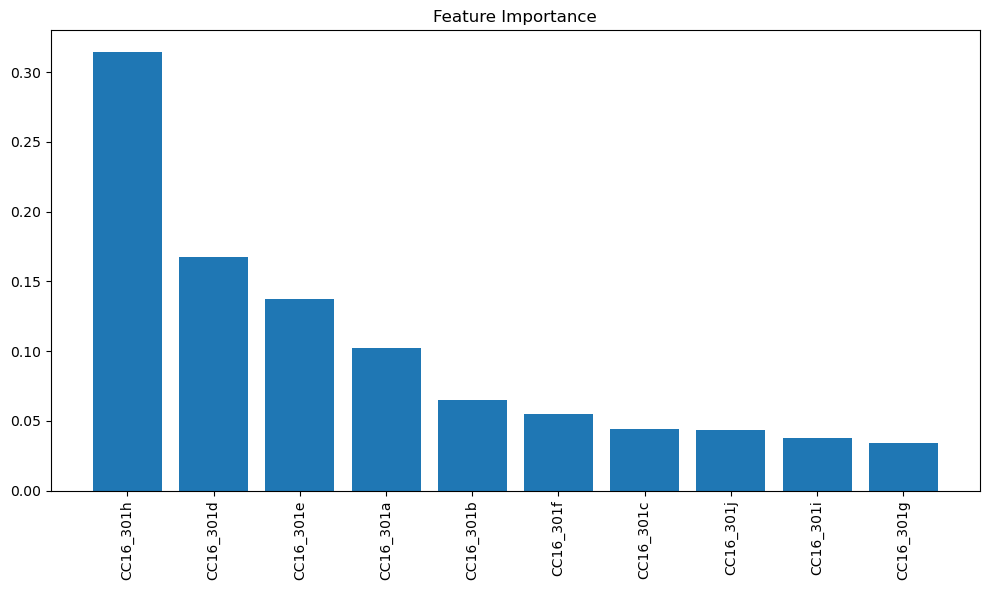

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# After training the model
feature_importances = model.feature_importances_

# Sort the feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()


In [65]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from ipywidgets import interact, IntSlider
import time
from IPython.display import display, clear_output

def plot_feature_importances(n_estimators):
    # Train the model with n_estimators
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)
    feature_importances = model.feature_importances_

    # Sort the feature importances
    sorted_idx = np.argsort(feature_importances)[::-1]

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.bar(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_idx], rotation=90)
    plt.title(f'Feature Importance for {n_estimators} Trees')
    plt.show()

# Create a slider to control the number of trees
slider = IntSlider(min=1, max=200, step=1, value=10, description='Number of Trees', continuous_update=False)

# Display the widget and plot
interact(plot_feature_importances, n_estimators=slider);


interactive(children=(IntSlider(value=10, continuous_update=False, description='Number of Trees', max=200, min…

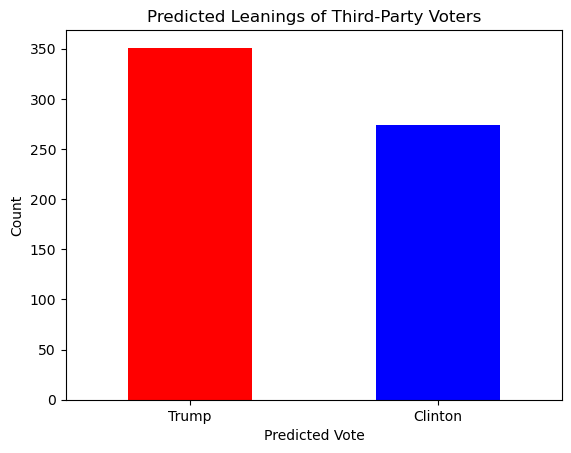

In [56]:
# Since we don't have the true labels for third-party voters, we can only predict their leaning
third_party_predictions = model.predict(X_test)

import matplotlib.pyplot as plt
def vis(predictions):
    # Count the number of predicted leanings
    predicted_counts = pd.Series(predictions).value_counts()

    # Create a bar chart
    predicted_counts.plot(kind='bar', color=['red', 'blue'])

    # Setting the title and labels
    plt.title('Predicted Leanings of Third-Party Voters')
    plt.xlabel('Predicted Vote')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1], labels=['Trump', 'Clinton'], rotation=0)  # 0 for Trump, 1 for Clinton

    # Show the plot
    plt.show()
vis(third_party_predictions)

In [58]:
gary_voters = data[data['CC16_410a'].isin(["Gary Johnson (Libertarian)"])]
g_test = gary_voters[features]

jill_voters = data[data['CC16_410a'].isin(["Jill Stein (Green)"])]
j_test = jill_voters[features]

evan_voters = data[data['CC16_410a'].isin(["Evan McMullin (Independent)"])]
e_test = evan_voters[features]


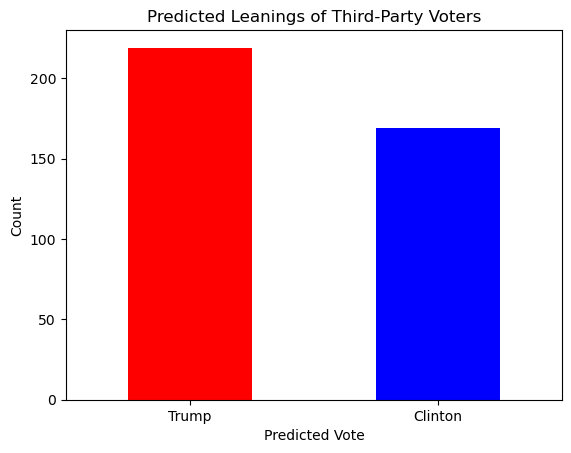

In [60]:
g_predictions = model.predict(g_test)
vis(g_predictions)

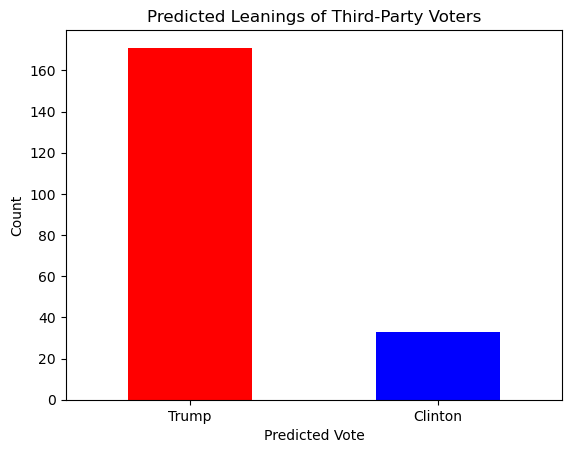

In [59]:
j_predictions = model.predict(j_test)
vis(j_predictions)

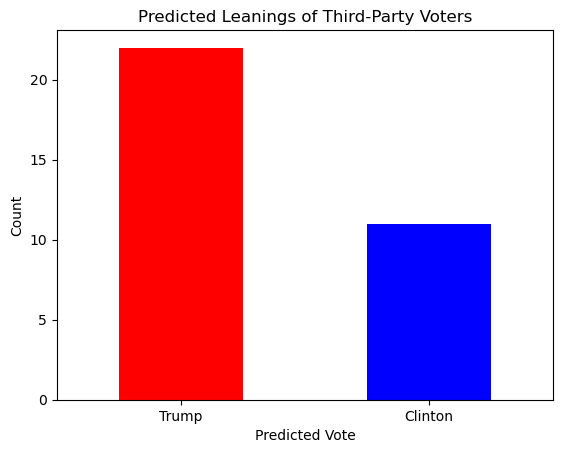

In [61]:
e_predictions = model.predict(e_test)
vis(e_predictions)